# Rod cutting with GA

Evolutionary Algorithms have a wide range of applications. One case in which they can be applied quite successfully is to solve optimization problems.\
In optimization problems, the objective is to find the input that produces a desired output given a known model. The search space consists of all possible inputs for the model. EAs provide a framework for exploring and evolving solutions within this search space.

The rod cutting problem is a well-known optimization problem. In this problem, we have a rod of length n and a table that specifies the price or value of selling different lengths of the rod. The goal is to find the optimal way to cut the rod into smaller pieces to maximize the total value obtained. The key constraint is that the rod can only be cut (and subsequently sold) at integer positions, meaning that the resulting pieces must have integer lengths.

This problem can be framed as a constrained optimization and the search space, comprising all possible compositions of n, has size $2^{n-1}$.

Rod cutting can also be seen as a variant of the knapsack problem, specifically the unbounded knapsack problem since items can be taken more than once. In this case, the length of the rod corresponds to the capacity of the knapsack and the available cutting options correspond to the items that can be placed into the knapsack.

Despite having a search space size that is exponential in the number of instances, this problem exhibits optimal substructure and overlapping subproblems. This makes it solvable in polynomial time using dynamic programming (not an NP-problem).
Nonetheless, it can still serve as a valuable example to illustrate how EAs can be applied to solve optimization problems.

For instance, in the following example, we have a rod of length 8 and the maximum revenue that we can get is 22 by splitting the rod into a piece of length 2 and a piece of length 6.

In [1]:
table = {1:1, 2:5, 3:8, 4:9, 5:10, 6:17, 7:17, 8:20}
table[2]+table[6]

22

In [2]:
import numpy as np
from copy import deepcopy
import random
np.random.seed(42)

### Representation

The first step when designing an evolutionary algorithm is to define the representation.

Defining the phenotype of individuals as the way in which a rod is split (e.g., one piece of length 2 and one of length 3), there are two possible representations for the genotype:
- Binary representation
- Integer representation

#### Binary representation 

A possible way to represent an individual is as a list of binary numbers of length n. In this representation, each element i is zero if there is no cut at position i, and one if we cut the rod at position i.

The fitness function is computed by iterating over the list and summing the values of pieces of different lengths.

In [3]:
class Rod_1:
    def __init__(self, l, table, init = ''):
        self.l = l
        self.rod = np.zeros(l-1, dtype = int)
        self.F = fitness_1(self, table)
        if init == 'random':
            self.random_init()
    def __repr__(self):
        s = ''
        for i in range(self.l-1):
            s += '[]'
            if self.rod[i] != 0:
                s += ' \ '
        s += '[]'
        return s
    
    def __eq__(self, other):
        return np.all(self.rod == other.rod)
    
    def random_init(self):
        n = np.random.randint(len(self.rod))
        i = np.random.randint(len(self.rod), size = n)
        self.rod[i] = 1

def fitness_1(ind, table):
    count = 1
    value = 0
    for i in ind.rod:
        if i == 1:
            value += table[count]
            count = 0
        count += 1
    
    value += table[count]
    return value

In [4]:
ind = Rod_1(8, table)
ind.rod[1] = 1
print(ind, ind.rod)
print('fitness:', fitness_1(ind, table))

[][] \ [][][][][][] [0 1 0 0 0 0 0]
fitness: 22


#### Integer representation

Another possible representation is a list of integers defining the length of each piece.

The fitness function is again computed by iterating over the list and summing the value of each piece.

In [5]:
class Rod_2:
    def __init__(self, l, table, init = ''):
        self.l = l
        self.rod = [l]
        self.F = fitness_2(self, table)
        if init == 'random':
            self.random_init()
    
    def __repr__(self):
        s = ''
        for i in self.rod:
            s += ('[]'*i)
            s += ' \ '
        return s
    
    def __eq__(self, other):
        return self.rod == other.rod
    
    def random_init(self):
        new_rod = []
        c = np.random.randint(1, self.l)
        n = self.l
        tot = 0

        for _ in range(c):
            value = np.random.randint(0, n - tot)
            new_rod.append(value)
            tot += value

        new_rod.append(n-tot)
        random.shuffle(new_rod)
        self.rod = [x for x in new_rod if x != 0]

def fitness_2(ind, table):
    rod = ind.rod
    value = 0
    for i in rod:
        value += table[i]
    return value

In [6]:
ind_2 = Rod_2(8, table)
ind_2.rod = [2,6]
print(ind_2, ind_2.rod)
print('fitness:', fitness_2(ind_2, table))

[][] \ [][][][][][] \  [2, 6]
fitness: 22


### Variation operators

The next step is to define variation operators. These mechanisms allow the population to change over time and explore the search space.

There are two main types of variation operators: mutation and recombination.

#### Mutation

Mutation is a unary operator, meaning it involves only one individual at a time, and it creates small random changes. Since it  changes one or more genes randomly, it can introduce new information into the genetic pool. Generally, the individuals change only slightly (although this may not be true for all representations), allowing for a finer search of the space.

The implementation of mutation depends on the chosen representation. For example, in the binary representation, mutation can be a simple bit-flipping operation where each gene is flipped with a probability of mr (mutation rate).

In [7]:
def simple_mutation_1(ind, mr):
    rod = ind.rod
    if np.random.rand() < mr:
        index = np.random.randint(ind.l-1)
        val = rod[index]
        if val == 0:
            rod[index] = 1
        if val == 1:
            rod[index] = 0

In the integer representation, mutation needs to be defined differently. Since we have a constraint on the length of the rod, we can implement mutation by either splitting one piece into two smaller ones or merging two pieces.

In this case, we also need a repair method (which will be useful for recombination as well) to ensure that the list sums up to n, satisfying the length constraint.

In [8]:
def simple_mutation_2(ind, mr):
    rod = ind.rod
    if np.random.rand() < mr:
        if np.random.rand()<0.5: #split one piece
            i = np.random.randint(len(rod))
            val = rod[i]
            new_val1 = np.random.randint(1, val+1)
            new_val2 = val - new_val1
            if new_val2 != 0:
                rod.append(new_val1)
                rod.append(new_val2)
                rod.sort()
        else: #merge two pieces
            if len(rod) != 1:
                i = np.random.randint(len(rod))
                j = i
                while i == j:
                    j = np.random.randint(len(rod))
                new_val = rod[i] + rod[j]
                if i > j:
                    del rod[i] 
                    del rod[j]
                else:
                    del rod[j]
                    del rod[i]
                rod.append(new_val)
                rod.sort()
        repair_2(ind)

def repair_2(ind):
    rod = ind.rod
    while sum(rod) > ind.l:
        i = np.random.randint(len(ind.rod))
        rod[i] -= 1
        if rod[i] == 0:
            del rod[i]
        
    while sum(rod) < ind.l:
        i = np.random.randint(len(rod))
        rod[i] += 1

#### Recombination

The other variation operator is recombination. Recombination can have an arity greater than or equal to two, meaning that the genetic material of two or more individuals is combined to create new offspring.

When the arity is equal to two, recombination is also called crossover. The simplest form of crossover is one-point crossover. For a chromosome of length n, 1-point crossover works by:
- choosing a random point in the interval [2, n-1]
- splitting the chromosomes of the two parents at that point.
- generatin new offspring by exchanging the two tails.

As for mutation the implementation of recombination differs for different representations. Additionally, for binary representation, besides simple one-point crossover, we can also implement:

- N-point crossover: n crossover points are chosen at random, the chromosomes are split along those points and offspring are created by joining parts, alternating between parents (In the following code only 2-point crossover is implemented.)
- Uniform crossover: for each gene, the first child has a uniform probability of inheriting from the first or the second parent. The second child is then generated by taking the inverse of the first.

Note that the crossover functions work only for individuals having a length of at least 4. However, this is not a significant restriction, as for rods of length smaller than 4, the result can be found easily by hand.

In [9]:
def simple_mutation_1(ind, mr):
    rod = ind.rod
    if np.random.rand() < mr:
        index = np.random.randint(ind.l-1)
        val = rod[index]
        if val == 0:
            rod[index] = 1
        if val == 1:
            rod[index] = 0
    
def one_point_crossover_1(p1, p2, cr):
    c1, c2 = deepcopy(p1), deepcopy(p2)
        
    if np.random.rand() < cr:
        pt = np.random.randint(1, p1.l-3)
        c1.rod = np.concatenate((p1.rod[:pt], p2.rod[pt:]))
        c2.rod = np.concatenate((p2.rod[:pt], p1.rod[pt:]))
    return c1, c2

def two_point_crossover_1(p1, p2, cr):
    c1, c2 = deepcopy(p1), deepcopy(p2)
    
    if np.random.rand() < cr:
        pt = np.random.choice(np.arange(1, p1.l-3), size=2, replace=False)
        pt = np.sort(pt)
        c1.rod = np.concatenate((p1.rod[:pt[0]], 
                                 p2.rod[pt[0]:pt[1]],
                                 p1.rod[pt[1]:]))
        
        c2.rod = np.concatenate((p2.rod[:pt[0]], 
                                 p1.rod[pt[0]:pt[1]],
                                 p2.rod[pt[1]:]))
    return c1, c2

def uniform_crossover(p1, p2, cr):
    c1, c2 = deepcopy(p1), deepcopy(p2)
    
    if np.random.rand() < cr:
        for i in range(p1.l-1):
            if np.random.rand() < 0.5:
                c1.rod[i] = p1.rod[i]
                c2.rod[i] = ~c1.rod[i]
            else: 
                c1.rod[i] = p2.rod[i]
                c2.rod[i] = ~c1.rod[i]
    return c1, c2 

The code for the integer representation is very similar to the binary representation, with the only difference being that we need to call the repair method after generating the children to ensure that the sum of the list is equal to n. 

By calling the repair method, we can handle cases where the recombination or crossover might have resulted in invalid rod lengths.

In [10]:
def one_point_crossover_2(p1, p2, cr):
    c1, c2 = deepcopy(p1), deepcopy(p2)
    
    if np.random.rand() < cr: 
        pt1 = np.random.randint(len(p1.rod))
        pt2 = np.random.randint(len(p2.rod))
            
        c1.rod = (p1.rod[:pt1]+p2.rod[pt2:]) 
        c2.rod = (p2.rod[:pt2]+p1.rod[pt1:])
    
        repair_2(c1)
        repair_2(c2)
    return c1, c2

### Selection

The first step in defining selection is choosing the population management model. Throughout the following code, the chosen model is the generational model, where the entire population is replaced at each generation. Each individual survives for exactly one generation. This approach is combined with elitism, which involves keeping a copy of the best individual found so far to ensure that very good solutions are not lost.

The next step is defining parent selection, which determines how individuals are chosen for reproduction. Two common ways to choose parents are:
- Roulette wheel selection: this mechanism mimics the concept of a roulette wheel, where the probability of selecting an individual is proportional to its fitness value. Intuitively, it works by spinning the arm of a roulette wheel, where the size of the segments on the wheel corresponds to the fitness of each individual.

- Tournament selection: here k individuals are randomly selected from the population to participate in a tournament. These individuals then compete against each other, through a fitness comparison, to determine the fittest individual among them. The fittest individual is then chosen as a parent for reproduction, passing on its genetic material to the next generation. The advantages of tournament selection are that it does not need to knowledge of whole population and the selection pressure can be adjusted by changing the parameter k (larger tournament make it more difficult for individuals with low fitness to be selected for reproduction) 

These selection methods play a crucial role in evolutionary algorithms as they determine the individuals that will contribute their genetic material to the next generation

In [11]:
def roulette_wheel_selection(pop):
    population_score = np.sum([s.F for s in pop])
    probabilities = [s.F/population_score for s in pop]
    selected = np.random.choice(pop, p=probabilities)

    return selected

def tournament_selection(pop, k):
    selected = np.random.choice(pop)
    for s in np.random.choice(pop, k-1):
        if s.F > selected.F:
            selected = s
    return selected

### Algorithm

We can now proceed to set up the algorithm that will solve the problem. The function takes the following parameters:
- table: A table of prices used to compute the revenue.
- rep: Determines which of the two representations should be used.
- fitness_function: The fitness function that evaluates the individuals.
- selection: The selection mechanism to be used, such as roulette wheel or tournament selection.
- crossover: The crossover mechanism for combining genetic material.
- mutation: The mutation mechanism for introducing random changes.
- init: Specifies whether individuals should be initialized randomly or not. The option 'nrandom' indicates not random initialization.
- n_generations: The number of generations the algorithm will run.
- n_individuals: The number of individuals in each generation.
- mr: The mutation rate, which represents the probability of having a mutation.
- cr: The crossover rate, which represents the probability of having a crossover.
- k: The number of individuals that compete in a tournament (if selection is tournament selection).

In addition to the best individual and its fitness, the algorithm also returns the generation in which the best individual was found. Furthermore, it provides a dictionary containing the diversity throughout the generations. Diversity is measured by taking the unique elements of the population, where diversity equal to 1 indicates that all individuals are the same.

Since the algorithm is stochastic, an additional function called trials is used to run the algorithm multiple times and evaluate the results. This helps to account for the randomness inherent in the algorithm and obtain a more reliable assessment of its performance.

In [12]:
def run(table, rep, function, selection, crossover, mutation, init,
           n_generations=10, n_individuals=10, mr=0.05, cr=0.2, k=2):
    pop = []
    l = len(table)
    for _ in range(n_individuals):
        s = rep(l, table, init)
        pop.append(s)

    best, best_score = pop[0], pop[0].F
    gen_opt = 0
    diversity = {}
    for gen in range(n_generations): 
        count = 0
        for s in pop:
            s.F = function(s, table)
            if s.F > best_score:
                best = s
                best_score = s.F  
                gen_opt = gen
            
            if selection is tournament_selection:
                selected = [selection(pop, k) for _ in range(n_individuals)]
            else: 
                selected = [selection(pop) for _ in range(n_individuals)]
            children = []
            for i in range(0, n_individuals, 2):
                p1, p2 = selected[i], selected[i+1]
                c1, c2 = crossover(p1, p2, cr)
            
                mutation(c1, mr)
                mutation(c2, mr)
                
                children.append(c1)
                children.append(c2)
            
                pop = children[:]
            
            for s in pop:
                s.F = function(s, table)

                if s.F > best_score:
                    best = s
                    best_score = s.F
                    gen_opt = gen
        count = []
        for x in pop:
            if x not in count:
                count.append(x)
        diversity[gen] = len(count)
    return best, best.F, gen_opt, diversity

def trial(nruns, table, rep, function, selection, mutation, crossover, init,
          n_generations=10, n_individuals=10, mr=0.05, cr=0.1, k=3):
    res, res_fit, gen, div = [], [], [], []
    for i in range(nruns):
        a, b, c, d= run(table, rep, function, selection, crossover, mutation, init,
                      n_generations, n_individuals, mr, cr, k)
        res.append(a)
        res_fit.append(b)
        gen.append(c)
        div.append(d)
    return res, res_fit, gen, div

In [13]:
nruns = 8
res1, res1_fit, gen1, div1= trial(nruns,
                           table = table, 
                           rep = Rod_1, 
                           function = fitness_1, 
                           selection = tournament_selection,
                           mutation = simple_mutation_1, 
                           crossover= one_point_crossover_1,
                           init = 'nrandom')
res2, res2_fit, gen2, div2 = trial(nruns,
                           table = table, 
                           rep = Rod_2, 
                           function = fitness_2, 
                           selection = tournament_selection,
                           mutation = simple_mutation_2, 
                           crossover= one_point_crossover_2,
                           init = 'nrandom')

print('Results:', res1_fit)
print('Results:', res2_fit)

Results: [22, 22, 22, 22, 22, 22, 22, 22]
Results: [22, 22, 22, 22, 22, 22, 22, 22]


Given that this problem can be solved efficiently with dynamic programming, we can compare the results of the algorithm to the global optimal solution. 

The result is that for this very simple problem, both choices of parameters have a 100% success rate.

In [14]:
def rod_cutting(n, prices):
    dp = [0] * (n + 1)
    cuts = []

    for i in range(1, n + 1):
        max_value = float('-inf')
        cut = None

        for j in range(1, i + 1):
            if prices[j] + dp[i - j] > max_value:
                max_value = prices[j] + dp[i - j]
                cut = j

        dp[i] = max_value
        cuts.append(cut)

    optimal_cuts = []
    while n > 0:
        cut = cuts[n - 1]
        optimal_cuts.append(cut)
        n -= cut

    return dp[-1], optimal_cuts

prices = list(table.values())
prices_2 = np.array([0] + prices)
n = len(prices)
rod_cut = rod_cutting(n, prices_2)
print("Maximum obtained value is", rod_cut[0])
print('Optimal split is', rod_cut[1])

Maximum obtained value is 22
Optimal split is [2, 6]


We can also test this approach on different and more complex problem instances.

For instance, we can generate a table of prices where each piece of length i has a value of i. Then, with probability increasing in the length, the value of each piece is randomly changed to an integer slightly higher than i.
The range of the new value is chosen to be larger as i increases. This approach is used because the impact of increasing the value by one unit is higher for smaller i values. For example, if a value of 1 is changed to 4, the optimal cut would almost certainly be to keep all pieces as 1. On the other hand, if a value of 30 is changed to 34, the impact may be much smaller and we avoid a bias toward smaller pieces.

In [15]:
table_2 = {}
for i in range(1, 30):
    table_2[i] = i
    if np.random.rand()<(0.1*i):
        table_2[i] = np.random.randint(i, np.round(i+np.log(i+1)))

print(table_2)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 6, 6: 6, 7: 7, 8: 8, 9: 10, 10: 10, 11: 11, 12: 14, 13: 15, 14: 14, 15: 16, 16: 17, 17: 18, 18: 20, 19: 19, 20: 22, 21: 21, 22: 22, 23: 23, 24: 26, 25: 25, 26: 28, 27: 29, 28: 30, 29: 30}


In [16]:
nruns = 4
res12, res12_fit, gen12, div12= trial(nruns,
                           table = table_2, 
                           rep = Rod_1, 
                           function = fitness_1, 
                           selection = tournament_selection,
                           mutation = simple_mutation_1, 
                           crossover= one_point_crossover_1,
                           init = 'nrandom')

res22, res22_fit, gen22, div22= trial(nruns,
                           table = table_2, 
                           rep = Rod_2, 
                           function = fitness_2, 
                           selection = tournament_selection,
                           mutation = simple_mutation_2, 
                           crossover= one_point_crossover_2,
                           init = 'nrandom')

print('Results:', res12_fit)
print('Results:', res22_fit)

prices = list(table_2.values())
prices_2 = np.array([0] + prices)
n = len(prices)
rod_cut = rod_cutting(n, prices_2)
print("Maximum obtained value is", rod_cut[0])
print('Optimal split is', rod_cut[1])


Results: [33, 33, 33, 33]
Results: [33, 33, 32, 33]
Maximum obtained value is 34
Optimal split is [1, 1, 1, 1, 5, 5, 5, 5, 5]


Using these parameters, both representations get stuck in a local optimum with a revenue equal to 33. Since the goal of the problem is to find the optimal solution rather than settling for "good enough" solutions we need to explore different parameter settings.

For instance we can:
- test different crossover mechanism such as uniform or 2-point crossover to explore fitness landscape in different ways
- increase the crossover and mutation rate to allow the algorithm to explore the solution space more extensively and increase the chances of finding the global optimum
- change the selection mechanism or change the size of the tournament to increase/decrease the selection pressure

In [17]:
nruns = 10
res13, res13_fit, gen13, div13 = trial(nruns,
                                    table = table_2, 
                                    rep = Rod_1, 
                                    function = fitness_1, 
                                    selection = tournament_selection,
                                    mutation = simple_mutation_1, 
                                    crossover= uniform_crossover,
                                    init = 'random', 
                                    k = 4,
                                    mr = 0.05,
                                    cr = 0.2)

res23, res23_fit, gen23, div23= trial(nruns,
                                    table = table_2, 
                                    rep = Rod_1, 
                                    function = fitness_1, 
                                    selection = roulette_wheel_selection,
                                    mutation = simple_mutation_1, 
                                    crossover= two_point_crossover_1,
                                    init = 'nrandom', 
                                    mr = 0.4,
                                    cr = 0.5)

res33, res33_fit, gen33, div33 = trial(nruns,
                                    table = table_2, 
                                    rep = Rod_2, 
                                    function = fitness_2, 
                                    selection = tournament_selection,
                                    mutation = simple_mutation_2, 
                                    crossover= one_point_crossover_2,
                                    init = 'nrandom',
                                    k = 4,
                                    mr = 0.3,
                                    cr = 0.5)

print('Results:', res13_fit, 'found in generations:', gen13)
print('Results:', res23_fit, 'found in generations:', gen23)
print('Results:', res33_fit, 'found in generations:', gen33)

Results: [33, 33, 32, 31, 32, 33, 33, 31, 33, 33] found in generations: [7, 1, 1, 0, 4, 0, 1, 0, 1, 0]
Results: [33, 33, 32, 33, 33, 33, 33, 33, 33, 32] found in generations: [0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Results: [34, 33, 34, 34, 34, 34, 34, 34, 33, 34] found in generations: [7, 1, 5, 1, 2, 6, 3, 5, 3, 2]


After trying some combination of parameters (only some of them shown above) the result obtained is that the best representation is a list of integers, the best selecion mechanism is tournament selection with an higher selection pressure (k=4 rathern than k=2) and it is beneficial to increase both the crossover rate (from 0.2 to 0.5) and the mutation rate (from 0.1 to 0.3).

It is worth noting that the algorithm using roulette wheel selection immediately gets stuck in a local optimum. This is due to the fact that only parents with high fitness values are used for recombination, limiting the exploration of the solution space and leading to early convergence. However, by utilizing tournament selection with sufficient selection pressure, this issue is mitigated as the selection process becomes less dependent on fitness values, resulting in a slower convergence towards the optimal solution.

Furthermore, it is interesting to see that the third algorithm manages to escape local optima and find the best solution thanks to its ability to preserve diversity within the population. For instance looking at algorithm 13 and 33 it is clear that the optimal combination of parameters maintains higher diversity troughout all generations in most of the runs.

In [18]:
for i in range(len(div13)):
    print(i, div13[i])
print('\n')
for i in range(len(div33)):
    print(i, div33[i])

0 {0: 5, 1: 2, 2: 2, 3: 5, 4: 3, 5: 3, 6: 2, 7: 3, 8: 2, 9: 3}
1 {0: 3, 1: 1, 2: 3, 3: 2, 4: 5, 5: 3, 6: 2, 7: 1, 8: 1, 9: 3}
2 {0: 3, 1: 3, 2: 2, 3: 2, 4: 4, 5: 2, 6: 2, 7: 4, 8: 3, 9: 4}
3 {0: 3, 1: 2, 2: 2, 3: 2, 4: 1, 5: 2, 6: 1, 7: 4, 8: 3, 9: 2}
4 {0: 2, 1: 3, 2: 4, 3: 6, 4: 1, 5: 1, 6: 3, 7: 2, 8: 2, 9: 2}
5 {0: 1, 1: 2, 2: 4, 3: 3, 4: 3, 5: 4, 6: 2, 7: 2, 8: 2, 9: 2}
6 {0: 2, 1: 4, 2: 3, 3: 2, 4: 3, 5: 1, 6: 2, 7: 2, 8: 3, 9: 6}
7 {0: 3, 1: 1, 2: 3, 3: 4, 4: 4, 5: 2, 6: 5, 7: 3, 8: 3, 9: 4}
8 {0: 7, 1: 2, 2: 3, 3: 2, 4: 5, 5: 2, 6: 2, 7: 2, 8: 2, 9: 3}
9 {0: 1, 1: 1, 2: 2, 3: 1, 4: 3, 5: 1, 6: 3, 7: 2, 8: 2, 9: 2}


0 {0: 5, 1: 5, 2: 4, 3: 7, 4: 6, 5: 7, 6: 9, 7: 9, 8: 7, 9: 7}
1 {0: 5, 1: 9, 2: 7, 3: 4, 4: 4, 5: 10, 6: 7, 7: 9, 8: 7, 9: 8}
2 {0: 5, 1: 8, 2: 10, 3: 7, 4: 8, 5: 6, 6: 9, 7: 8, 8: 8, 9: 5}
3 {0: 8, 1: 6, 2: 6, 3: 9, 4: 8, 5: 7, 6: 5, 7: 8, 8: 9, 9: 7}
4 {0: 7, 1: 9, 2: 6, 3: 7, 4: 5, 5: 7, 6: 6, 7: 5, 8: 10, 9: 10}
5 {0: 9, 1: 9, 2: 10, 3: 8, 4: 6, 5: 7, 6: 8, 7: 

The best result obtained (success rate almost 100%) is:
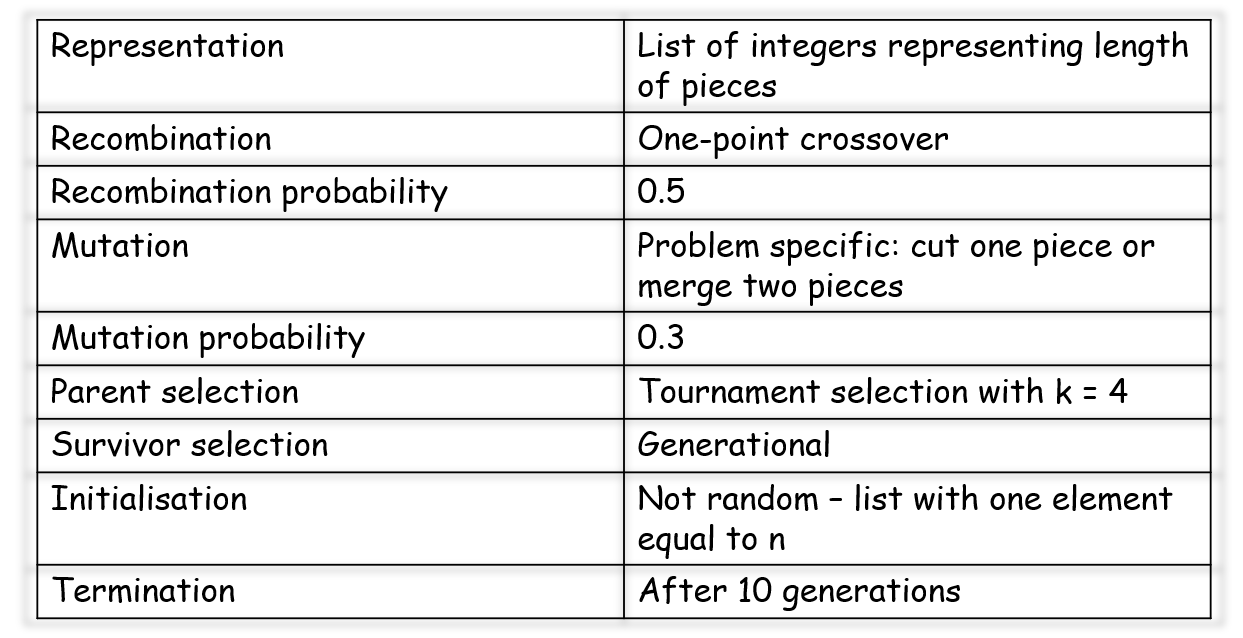

The optimality of this choice of parameters is not restricted to one specific problem instance. As shown in the following code the algorithm consitently finds solutions, in the majority of cases, with different price tables.

In [19]:
times = 8
for x in range(times):
    table_3 = {}
    for i in range(1, 30):
        table_3[i] = i
        if np.random.rand()<(0.5*i):
            table_3[i] = np.random.randint(i, np.round(i+np.log(i+1)))

    res, res_fit, gen, div= trial(nruns,
                        table = table_3, 
                        rep = Rod_2, 
                        function = fitness_2, 
                        selection = tournament_selection,
                        mutation = simple_mutation_2, 
                        crossover= one_point_crossover_2,
                        init = 'nrandom',
                        k = 4,
                        mr = 0.3,
                        cr = 0.5)
    
    prices = list(table_3.values())
    prices_2 = np.array([0] + prices)
    n = len(prices)
    rod_cut = rod_cutting(n, prices_2)
    
    sr = np.sum(np.array(res_fit)==rod_cut[0])/nruns * 100
    
    print('Table:', table_3)
    print('Optimal revenue:',  rod_cut[0], 'optimal cut:', rod_cut[1])
    print(res_fit)
    print('Success rate:', sr, '\n')

Table: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 7, 7: 8, 8: 9, 9: 10, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 17, 16: 17, 17: 18, 18: 20, 19: 21, 20: 20, 21: 23, 22: 22, 23: 25, 24: 24, 25: 27, 26: 26, 27: 29, 28: 28, 29: 29}
Optimal revenue: 33 optimal cut: [1, 1, 1, 1, 1, 6, 6, 6, 6]
[33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
Success rate: 100.0 

Table: {1: 1, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: 8, 8: 8, 9: 10, 10: 11, 11: 11, 12: 14, 13: 14, 14: 14, 15: 16, 16: 18, 17: 18, 18: 19, 19: 19, 20: 21, 21: 23, 22: 24, 23: 25, 24: 26, 25: 25, 26: 27, 27: 27, 28: 29, 29: 30}
Optimal revenue: 36 optimal cut: [1, 4, 4, 4, 4, 4, 4, 4]
[35, 35, 35, 34, 36, 36, 34, 35, 35, 35]
Success rate: 20.0 

Table: {1: 1, 2: 2, 3: 3, 4: 4, 5: 6, 6: 6, 7: 8, 8: 9, 9: 9, 10: 11, 11: 11, 12: 14, 13: 14, 14: 15, 15: 15, 16: 18, 17: 17, 18: 19, 19: 19, 20: 21, 21: 21, 22: 23, 23: 24, 24: 24, 25: 27, 26: 28, 27: 27, 28: 28, 29: 29}
Optimal revenue: 34 optimal cut: [1, 1, 1, 1, 5, 5, 5, 5, 5]
[34, 34, 34, 34, 34, 34, 34